In [119]:
import math
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from networkx.algorithms.approximation.clustering_coefficient import average_clustering
from networkx.algorithms.distance_measures import eccentricity, diameter
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.centrality import eigenvector_centrality, betweenness_centrality, closeness_centrality
from networkx.algorithms.community.kclique import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities, coverage, performance
from networkx.algorithms.community.label_propagation import label_propagation_communities
from networkx.algorithms.community.quality import performance
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.asyn_fluid import asyn_fluidc
from networkx.generators.degree_seq import expected_degree_graph
from networkx.linalg.graphmatrix import adjacency_matrix
import Levenshtein as lev
import csv

In [58]:
def createGraph():
    G = nx.Graph()
    with open('movie_metadata.csv', newline='', encoding="utf8") as csvfile:
        moviereader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for idx, row in enumerate(moviereader):
            if (idx == 0 or not (len(row) == 28)): continue # Skip invalid data
            movie_title = row[11]
            actor_1_name = row[10]
            actor_2_name = row[6]
            actor_3_name = row[14]
            G.add_node(actor_1_name) # Note: duplicates are handled by NetworkX
            G.add_node(actor_2_name)
            G.add_node(actor_3_name)
            attr_dict1 = G.get_edge_data(actor_1_name, actor_2_name, {"movies": []})
            attr_dict1["movies"].append(row)
            G.add_edge(actor_1_name, actor_2_name, movies=attr_dict1["movies"])
            attr_dict2 = G.get_edge_data(actor_2_name, actor_3_name, {"movies": []})
            attr_dict2["movies"].append(row)   
            G.add_edge(actor_2_name, actor_3_name, movies=attr_dict2["movies"])
            attr_dict3 = G.get_edge_data(actor_3_name, actor_1_name, {"movies": []})
            attr_dict3["movies"].append(row)   
            G.add_edge(actor_3_name, actor_1_name, movies=attr_dict3["movies"])
        return G
graph = createGraph()

In [82]:
# Nodes
print("Total number of nodes: " + str(len(graph.nodes)))
# Edges
print("Total number of edges: " + str(len(graph.edges)))
# Components
components = sorted(nx.connected_components(graph), key=len, reverse=True)
print("Total number of components: " + str(len(components)))
# Adjacency matrix
adjMatrix = adjacency_matrix(graph).todense()
for row in range(0, 8):
    rowstring = ""
    for col in range(0, 8):
        rowstring += str(adjMatrix.item((col, row))) + " &"
    print(rowstring + "\\\\")

Total number of nodes: 6182
Total number of edges: 14171
Total number of components: 496
0 &1 &1 &0 &0 &0 &0 &0 &\\
1 &0 &1 &0 &0 &0 &0 &0 &\\
1 &1 &0 &0 &0 &0 &0 &0 &\\
0 &0 &0 &0 &1 &1 &0 &0 &\\
0 &0 &0 &1 &0 &1 &0 &0 &\\
0 &0 &0 &1 &1 &0 &0 &0 &\\
0 &0 &0 &0 &0 &0 &0 &1 &\\
0 &0 &0 &0 &0 &0 &1 &0 &\\


In [ ]:
def printProperties(graph):
    # Clustering coefficient
    print("Estimated average clustering coefficient: " + str(average_clustering(graph, trials=10000, seed=None)))
    # Diameter 
    diameters = []
    comps = sorted(nx.connected_components(graph), key=len, reverse=True)
    for comp in components:
        nodes = len(graph.subgraph(comp).nodes)
        if (nodes == 0): continue
        diameters.append(diameter(graph.subgraph(comp)))
    print("Diameter: " + str(max(diameters)))
    # Giant Component
    gc = graph.subgraph(components[0])                     
    print("Size of giant component: " + str(len(gc.nodes)))
    # Average path length of GC
    print("Average path length of giant component: " + str(average_shortest_path_length(gc)))
# printProperties(graph)

In [17]:
# Component sizes
component_sizes = []
for comp in components: component_sizes.append(len(comp))
for i in range(0, 10): print("Component " + str(i+1) + ": " + str(component_sizes[i]))
print("Total: " + str(len(component_sizes)) + " components")

Component 1: 4600
Component 2: 11
Component 3: 7
Component 4: 7
Component 5: 7
Component 6: 7
Component 7: 7
Component 8: 6
Component 9: 5
Component 10: 5
Total: 496 components


In [5]:
# Centralities
minDegree = None
maxDegree = None
avgDegree = 0
degreeCentralityDict = {}
minEvCentrality = None
maxEvCentrality = None
avgEvCentrality = 0
evCentralityDict = eigenvector_centrality(graph)
minBwCentrality = None
maxBwCentrality = None
avgBwCentrality = 0
bwCentralityDict = betweenness_centrality(graph)
minClsCentrality = None
maxClsCentrality = None
avgClsCentrality = 0
clsCentralityDict = closeness_centrality(graph)
for node in graph.nodes: 
    degree = graph.degree(node)
    minDegree = degree if (minDegree == None) else min(minDegree, degree)
    maxDegree = degree if (maxDegree == None) else max(maxDegree, degree)
    avgDegree += degree / (1.0 * len(graph.nodes))
    degreeCentralityDict[node] = degree
    minEvCentrality = evCentralityDict[node] if (minEvCentrality == None) else min(minEvCentrality, evCentralityDict[node])
    maxEvCentrality = evCentralityDict[node] if (maxEvCentrality == None) else max(maxEvCentrality, evCentralityDict[node])
    avgEvCentrality += evCentralityDict[node] / (1.0 * len(graph.nodes))
    minBwCentrality = bwCentralityDict[node] if (minBwCentrality == None) else min(minBwCentrality, bwCentralityDict[node])
    maxBwCentrality = bwCentralityDict[node] if (maxBwCentrality == None) else max(maxBwCentrality, bwCentralityDict[node])
    avgBwCentrality += bwCentralityDict[node] / (1.0 * len(graph.nodes))
    minClsCentrality = clsCentralityDict[node] if (minClsCentrality == None) else min(minClsCentrality, clsCentralityDict[node])
    maxClsCentrality = clsCentralityDict[node] if (maxClsCentrality == None) else max(maxClsCentrality, clsCentralityDict[node])
    avgClsCentrality += clsCentralityDict[node] / (1.0 * len(graph.nodes))
print("Maximum degree: " + str(maxDegree))
print("Average degree: " + str(avgDegree))
print("Maximum eigenvector centrality: " + str(maxEvCentrality))
print("Average eigenvector centrality: " + str(avgEvCentrality))
print("Maximum betweenness centrality: " + str(maxBwCentrality))
print("Average betweenness centrality: " + str(avgBwCentrality))
print("Maximum closeness centrality: " + str(maxClsCentrality))
print("Average closeness centrality: " + str(avgClsCentrality))

Maximum degree: 92
Average degree: 4.58460045292757
Maximum eigenvector centrality: 0.2028235964373131
Average eigenvector centrality: 0.004541559550872118
Maximum betweenness centrality: 0.029562044310021098
Average betweenness centrality: 0.0003474664505352846
Maximum closeness centrality: 0.23591216837400936
Average closeness centrality: 0.11651565442942045


<BarContainer object of 93 artists>

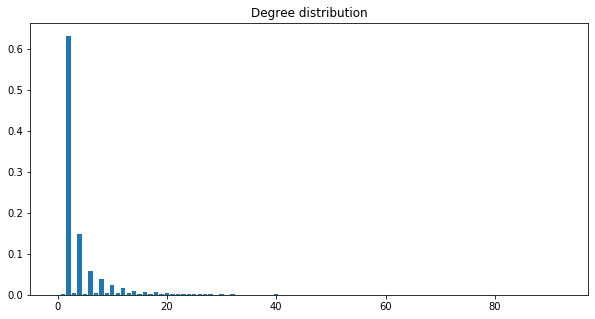

In [91]:
# Plot the degree distribution
bins = np.empty(maxDegree+1)
bins.fill(0)
for node in graph.nodes: 
    bins[graph.degree(node)] += 1
for i in range(0, len(bins)): bins[i] /= (1.0 * len(graph.nodes))
x = np.arange(0.0, maxDegree + 1.0, 1.0)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Degree distribution')
ax.bar(x, bins)

In [40]:
# 10 most ranked actors based on degree-, eigenvector-, in-betweenness-, and closeness centrality
sortedByDegree = sorted(degreeCentralityDict, key=degreeCentralityDict.get)
sortedByDegree.reverse()
sortedByDegree = sortedByDegree[:10]
print("Top 10 actors based on degree centrality: " + ', '.join(sortedByDegree))
sortedByEvCentrality = sorted(evCentralityDict, key=evCentralityDict.get)
sortedByEvCentrality.reverse()
sortedByEvCentrality = sortedByEvCentrality[:10]
print("Top 10 actors based on eigenvector centrality: " + ', '.join(sortedByEvCentrality))
sortedByBwCentrality = sorted(bwCentralityDict, key=bwCentralityDict.get)
sortedByBwCentrality.reverse()
sortedByBwCentrality = sortedByBwCentrality[:10]
print("Top 10 actors based on betweenness centrality: " + ', '.join(sortedByBwCentrality))
sortedByClsCentrality = sorted(clsCentralityDict, key=clsCentralityDict.get)
sortedByClsCentrality.reverse()
sortedByClsCentrality = sortedByClsCentrality[:10]
print("Top 10 actors based on closeness centrality: " + ', '.join(sortedByClsCentrality))

Top 10 actors based on degree centrality: Robert De Niro, Morgan Freeman, Matt Damon, Bruce Willis, Nicolas Cage, Johnny Depp, Denzel Washington, Will Ferrell, Liam Neeson, Bill Murray
Top 10 actors based on eigenvector centrality: Robert De Niro, Morgan Freeman, Brad Pitt, Johnny Depp, Matt Damon, Bruce Willis, Kirsten Dunst, Anthony Hopkins, Denzel Washington, Meryl Streep
Top 10 actors based on betweenness centrality: Robert De Niro, Morgan Freeman, Matt Damon, Bruce Willis, Denzel Washington, Nicolas Cage, Bill Murray, Will Ferrell, Johnny Depp, Jim Broadbent
Top 10 actors based on closeness centrality: Morgan Freeman, Robert De Niro, Matt Damon, Bruce Willis, Johnny Depp, Denzel Washington, Brad Pitt, Kirsten Dunst, Robert Duvall, Meryl Streep


In [109]:
# Communities
k_clique_3_comm = list(k_clique_communities(graph, 3))
k_clique_4_comm = list(k_clique_communities(graph, 4))
k_clique_5_comm = list(k_clique_communities(graph, 5))
greedy_modularity_comm = list(greedy_modularity_communities(graph))
label_propagation_comm = list(label_propagation_communities(graph))
print(len(k_clique_3_comm))
print(len(k_clique_4_comm))
print(len(k_clique_5_comm))
print(len(greedy_modularity_comm))
print(len(label_propagation_comm))

3515
40
2
591
1186


In [110]:
def coverage(graph, comm):
    intraCommunityEdges = 0
    overlap = {}
    for community in comm:
        for nodeA in community:
            for nodeB in community:
                if (graph.has_edge(nodeA, nodeB) and (nodeA, nodeB) not in overlap and (nodeB, nodeA) not in overlap): 
                    intraCommunityEdges += 1
                    overlap[(nodeA, nodeB)] = 1
                    overlap[(nodeB, nodeA)] = 1
    return intraCommunityEdges / (1.0 * len(graph.edges))
print(coverage(graph, k_clique_3_comm))
print(coverage(graph, k_clique_4_comm))
print(coverage(graph, k_clique_5_comm))
print(coverage(graph, greedy_modularity_comm))
print(coverage(graph, label_propagation_comm))

0.9996471667489945
0.02236962811375344
0.0016230329546256439
0.7343165619928022
0.8645825982640604


In [160]:
## Hypothesis: Communities correspond to movie categories (investigated for each algorithm)
for comm in [k_clique_3_comm, k_clique_4_comm, k_clique_5_comm, greedy_modularity_comm, label_propagation_comm, [graph.nodes]]:
    avg_p = 0.0
    k = 0
    for community in comm:
        if len(community) <= 3: continue
        k = k + 1
    for community in comm:
        if len(community) <= 3: continue
        categories = {}
        for edge in graph.edges(community):
            for movie in graph.get_edge_data(edge[0], edge[1])["movies"]:
                #for cat in movie[9].split('|'): 
                #    if (cat not in categories): categories[cat] = 0
                #    categories[cat] += 1 / len(movie[9].split('|')) # If movie has several categories, weight accordingly
                cat = movie[9]
                if (cat not in categories): categories[cat] = 0
                categories[cat] += 1
        p = max(list(categories.values())) / (1.0 * sum(list(categories.values())))
        avg_p += p / k
    print("Average probability of random movie selected from each community to be from the dominant category: " + str(avg_p))

## Hypothesis: Communities correspond to country of origin
for comm in [k_clique_3_comm, k_clique_4_comm, k_clique_5_comm, greedy_modularity_comm, label_propagation_comm, [graph.nodes]]:
    avg_p = 0.0
    k = 0
    for community in comm:
        if len(community) <= 3: continue
        k = k + 1
    for community in comm:
        if len(community) <= 3: continue
        for edge in graph.edges(community):
            for movie in graph.get_edge_data(edge[0], edge[1])["movies"]:
                country = movie[20]
                if (country not in countries): countries[country] = 0
                countries[country] += 1 # If movie has several categories, weight accordingly
        p = max(list(countries.values())) / (1.0 * sum(list(countries.values())))
        avg_p += p / k
    print("Average probability of random movie selected from each community to be from the dominant country: " + str(avg_p))

## Hypothesis: Communities correspond to director
for comm in [k_clique_3_comm, k_clique_4_comm, k_clique_5_comm, greedy_modularity_comm, label_propagation_comm, [graph.nodes]]:
    avg_p = 0.0
    k = 0
    for community in comm:
        if len(community) <= 3: continue
        k = k + 1
    for community in comm:
        if len(community) <= 3: continue
        directors = {}
        for edge in graph.edges(community):
            for movie in graph.get_edge_data(edge[0], edge[1])["movies"]:
                director = movie[1]
                if (director not in directors): directors[director] = 0
                directors[director] += 1 # If movie has several categories, weight accordingly
        p = max(list(directors.values())) / (1.0 * sum(list(directors.values())))
        avg_p += p / k
    print("Average probability of random movie selected from each community to be from the dominant director: " + str(avg_p))


Average probability of random movie selected from each community to be from the dominant category: 0.16986282572170128
Average probability of random movie selected from each community to be from the dominant category: 0.08793798504789002
Average probability of random movie selected from each community to be from the dominant category: 0.06076495464156606
Average probability of random movie selected from each community to be from the dominant category: 0.34890101433566606
Average probability of random movie selected from each community to be from the dominant category: 0.39662843148279875
Average probability of random movie selected from each community to be from the dominant category: 0.04664254121431444
Average probability of random movie selected from each community to be from the dominant country: 0.7888909511744199
Average probability of random movie selected from each community to be from the dominant country: 0.7896903148930017
Average probability of random movie selected from ea

In [165]:
# Actor ranking (average imdb score of all movies)
actorRankings = {}
minActorRanking = None
maxActorRanking = None
for node in graph.nodes:
    movieRankings = {}
    for edge in graph.edges([node]):
        attr_dict = graph.get_edge_data(edge[0], edge[1])
        movies = attr_dict["movies"]
        for movie in movies:
            title = movie[11]
            imdb_score = movie[25]
            if (title not in movieRankings): movieRankings[title] = float(imdb_score)
    avgMovieScore = sum(movieRankings.values()) / (1.0 * len(movieRankings.values()))
    actorRankings[node] = avgMovieScore
    minActorRanking = avgMovieScore if (minActorRanking == None) else min(minActorRanking, avgMovieScore)
    maxActorRanking = avgMovieScore if (maxActorRanking == None) else max(maxActorRanking, avgMovieScore)    


Distance between actor ranking histogram and normalized degree histogram: 0.6888762341027465
Distance between actor ranking histogram and normalized eigenvector centrality histogram: 0.7925268825462151
Distance between actor ranking histogram and normalized betweenness centrality histogram: 0.8954394892367591
Distance between actor ranking histogram and normalized closeness centrality histogram: 0.26476432299317304
...
...
Distance between actor ranking histogram and normalized degree histogram: 0.6045622860020075
Distance between actor ranking histogram and normalized eigenvector centrality histogram: 0.7232426717173486
Distance between actor ranking histogram and normalized betweenness centrality histogram: 0.8556420664832802
Distance between actor ranking histogram and normalized closeness centrality histogram: 0.06323882777514356


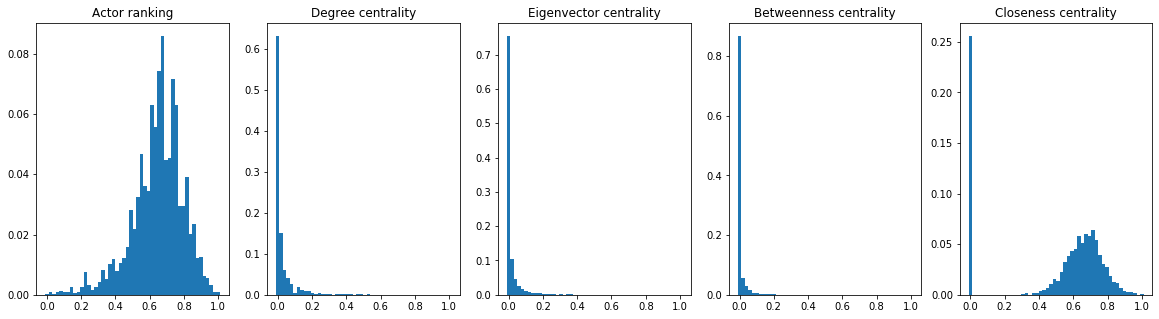

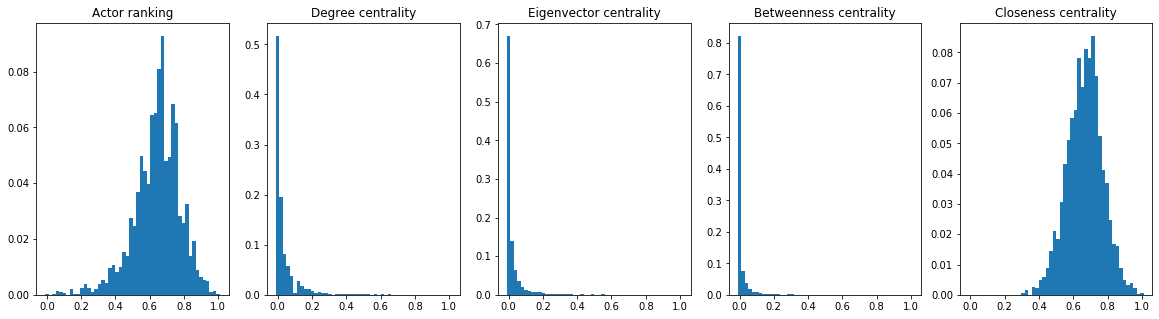

In [174]:
# Histograms of normalized actor ranking and centralities
def compareCentralities(graph):
    bins = 50
    actorRankingBins = []
    degreeCentralityBins = []
    evCentralityBins = []
    bwCentralityBins = []
    clsCentralityBins = []
    for i in range(0, bins):
        actorRankingBins.append(0)
        degreeCentralityBins.append(0)
        evCentralityBins.append(0)
        bwCentralityBins.append(0)
        clsCentralityBins.append(0)
    for node in graph.nodes:
        actorRankingBin = min(bins-1, math.floor(bins * (actorRankings[node] - minActorRanking) / (maxActorRanking - minActorRanking)))
        degreeCentralityBin = min(bins-1, math.floor(bins * (degreeCentralityDict[node] - minDegree) / (maxDegree - minDegree)))
        evCentralityBin = min(bins-1, math.floor(bins * (evCentralityDict[node] - minEvCentrality) / (maxEvCentrality - minEvCentrality)))
        bwCentralityBin = min(bins-1, math.floor(bins * (bwCentralityDict[node] - minBwCentrality) / (maxBwCentrality - minBwCentrality)))
        clsCentralityBin = min(bins-1, math.floor(bins * (clsCentralityDict[node] - minClsCentrality) / (maxClsCentrality - minClsCentrality)))
        actorRankingBins[actorRankingBin] += 1.0 / len(graph.nodes)
        degreeCentralityBins[degreeCentralityBin] += 1.0 / len(graph.nodes)
        evCentralityBins[evCentralityBin] += 1.0 / len(graph.nodes)
        bwCentralityBins[bwCentralityBin] += 1.0 / len(graph.nodes)
        clsCentralityBins[clsCentralityBin] += 1.0 / len(graph.nodes)
    # Plot histograms
    x = np.linspace(0.0, 1.0, bins)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax1 = plt.subplot(1, 5, 1)
    ax1.title.set_text("Actor ranking")
    plt.bar(x, actorRankingBins, width=1.0/(bins-1.0))
    ax2 = plt.subplot(1, 5, 2)
    ax2.title.set_text("Degree centrality")
    plt.bar(x, degreeCentralityBins, width=1.0/(bins-1.0))
    ax3 = plt.subplot(1, 5, 3)
    ax3.title.set_text("Eigenvector centrality")
    plt.bar(x, evCentralityBins, width=1.0/(bins-1.0))
    ax4 = plt.subplot(1, 5, 4)
    ax4.title.set_text("Betweenness centrality")
    plt.bar(x, bwCentralityBins, width=1.0/(bins-1.0))
    ax5 = plt.subplot(1, 5, 5)
    ax5.title.set_text("Closeness centrality")
    plt.bar(x, clsCentralityBins, width=1.0/(bins-1.0))
    # Euclidean distance between histograms
    degreeDist = 0.0
    evDist = 0.0
    bwDist = 0.0
    clsDist = 0.0
    for i in range(0, bins):
        degreeDist += (actorRankingBins[i] - degreeCentralityBins[i]) * (actorRankingBins[i] - degreeCentralityBins[i])
        evDist += (actorRankingBins[i] - evCentralityBins[i]) * (actorRankingBins[i] - evCentralityBins[i])    
        bwDist += (actorRankingBins[i] - bwCentralityBins[i]) * (actorRankingBins[i] - bwCentralityBins[i])    
        clsDist += (actorRankingBins[i] - clsCentralityBins[i]) * (actorRankingBins[i] - clsCentralityBins[i])
    degreeDist = math.sqrt(degreeDist)
    evDist = math.sqrt(evDist)
    bwDist = math.sqrt(bwDist)
    clsDist = math.sqrt(clsDist)
    print("Distance between actor ranking histogram and normalized degree histogram: " + str(degreeDist))
    print("Distance between actor ranking histogram and normalized eigenvector centrality histogram: " + str(evDist))
    print("Distance between actor ranking histogram and normalized betweenness centrality histogram: " + str(bwDist))
    print("Distance between actor ranking histogram and normalized closeness centrality histogram: " + str(clsDist))
compareCentralities(graph)
print("...")
gc = graph.subgraph(components[0])
print("...")
compareCentralities(gc)

In [192]:
# Pick 5 best matching from 100 random graphs
def degree_histogram_distance(g1, g2):
    assert(len(g1.nodes) == len(g2.nodes))
    g1_max_degree = None
    g2_max_degree = None
    for node in g1.nodes:
        g1_max_degree = g1.degree(node) if (g1_max_degree == None) else max(g1_max_degree, g1.degree(node))
    for node in g2.nodes:
        g2_max_degree = g2.degree(node) if (g2_max_degree == None) else max(g2_max_degree, g2.degree(node))
    g1_bins = [] 
    g2_bins = []
    for i in range(0, max(g1_max_degree, g2_max_degree) + 1):
        g1_bins.append(0)
        g2_bins.append(0)
    for node in g1.nodes:
        g1_bins[g1.degree(node)] += 1
    for node in g2.nodes:
        g2_bins[g2.degree(node)] += 1
    result = 0
    for i in range(0, max(g1_max_degree, g2_max_degree) + 1):
        result += (g1_bins[i] - g2_bins[i]) * (g1_bins[i] - g2_bins[i])
    result = math.sqrt(result)
    return result
def printRndGraphProperties(graph):
    # Clustering coefficient
    print("Estimated average clustering coefficient: " + str(average_clustering(graph, trials=10000, seed=None)))
    # Giant Component
    comps = sorted(nx.connected_components(graph), key=len, reverse=True)
    gc = graph.subgraph(comps[0])                     
    print("Size of giant component: " + str(len(gc.nodes)))
    # Average path length of GC
    print("Average path length of giant component: " + str(average_shortest_path_length(gc)))
w = []
for node in graph.nodes: w.append(graph.degree(node))
rnd_graphs = []
for i in range(0, 100):
    rnd_graph = expected_degree_graph(w, selfloops=False)
    rnd_graphs.append(rnd_graph)
def key_fn(g):
    d = degree_histogram_distance(graph, g)
    return degree_histogram_distance(graph, g)
rnd_graphs = sorted(rnd_graphs, key=key_fn)[:5]
for g in rnd_graphs:
    print(degree_histogram_distance(graph, g))
# Plot histograms
    x = np.linspace(0.0, 1.0, bins)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax1 = plt.subplot(1, 6, 1)
    ax1.title.set_text("Original")
    plt.bar(x, rnd_graphs, width=1.0/(bins-1.0))
    ax2 = plt.subplot(1, 6, 2)
    ax2.title.set_text("Random Graph 1")
    plt.bar(x, degreeCentralityBins, width=1.0/(bins-1.0))
    ax3 = plt.subplot(1, 6, 3)
    ax3.title.set_text("Random Graph 2")
    plt.bar(x, evCentralityBins, width=1.0/(bins-1.0))
    ax4 = plt.subplot(1, 6, 4)
    ax4.title.set_text("Random Graph 3")
    plt.bar(x, bwCentralityBins, width=1.0/(bins-1.0))
    ax5 = plt.subplot(1, 6, 5)
    ax5.title.set_text("Random Graph 4")
    plt.bar(x, clsCentralityBins, width=1.0/(bins-1.0))
    ax6 = plt.subplot(1, 6, 6)
    ax6.title.set_text("Random Graph 5")
    plt.bar(x, clsCentralityBins, width=1.0/(bins-1.0))

3061.498325983537
3074.8453619653787
3076.5275880446775
3080.0444801982976
3090.1799300364373


25
24
